# Credit default prediction with MLP

This example will serve as a first hands-on experience with neural networks training using PyTorch. In this notebook, we will learn how to train a basic Multilayered Perceptron (MLP) and how to find good hyperparameters with the Hyperopt library. To achieve this, we will be experimenting with a credit card default dataset which was obtained from the UCI machine learning repository:

https://archive.ics.uci.edu/ml/datasets/default+of+credit+card+clients

No need to download it from the original repository! We have it on our google drive and we will get it from there in the next cells.

Let's begin by installing the packages that we will need today.

In [1]:
!pip3 install torch
!pip3 install hyperopt
!pip3 install googledrivedownloader
!pip3 install tqdm

You are using pip version 19.0.3, however version 19.3.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
    100% |████████████████████████████████| 1.9MB 2.6MB/s ta 0:00:011
    100% |████████████████████████████████| 829kB 1.4MB/s ta 0:00:011
    100% |████████████████████████████████| 1.7MB 1.5MB/s ta 0:00:011
  Stored in directory: /Users/jean-francis/Library/Caches/pip/wheels/8b/99/a0/81daf51dcd359a9377b110a8a886b3895921802d2fc1b2397e
  Stored in directory: /Users/jean-francis/Library/Caches/pip/wheels/68/f8/29/b53346a112a07d30a5a84d53f19aeadaa1a474897c0423af91
Successfully built future networkx
You are using pip version 19.0.3, however version 19.3.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
You are using pip version 19.0.3, however version 19.3.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
You are using pip version 19.0.3, however version 19.3.1 is

And of course importing them...

In [2]:
# To download our dataset
from google_drive_downloader import GoogleDriveDownloader

# Visualization
from tqdm import tqdm_notebook as tqdm
import matplotlib.pyplot as plt

# Data manipulation
import pandas as pd
import numpy as np

# Deep learning
import torch
from torch.optim import Adam
import torch.nn as nn
import torch.nn.functional as F

# Preprocessing and scoring
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, log_loss, precision_recall_curve
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
#from sklearn.utils.fixes import 

# Hyperparameter tuning
from hyperopt import space_eval
from hyperopt import fmin, hp, tpe

Finally, we can download the credit default dataset using the unique Google Drive ID attached to it and save it directly in our current path.

In [3]:
CREDIT_ID = '1c0EKXaupL9Y_ttxKm0ujhnZ3QSYXNO9f'

GoogleDriveDownloader.download_file_from_google_drive(file_id=CREDIT_ID,
                                                      dest_path='./credit_data',
                                                      unzip=True)

Unzipping...Done.


Great, we now have all the tools that we need. Let's take a look at the data.

In [4]:
credit_df = pd.read_csv('./UCI_Credit_Card.csv').drop('ID', axis=1).drop_duplicates()

print('Nb. examples, Nb. features : {}'.format(credit_df.shape))
print('Proportion of default: {}'.format(credit_df.iloc[:,-1].mean()))

credit_df.head(10)

Nb. examples, Nb. features : (29965, 24)
Proportion of default: 0.22125813449023862


,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default.payment.next.month
0,20000.0,2,2,1,24,2,2,-1,-1,-2,...,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0,1
1,120000.0,2,2,2,26,-1,2,0,0,0,...,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0,1
2,90000.0,2,2,2,34,0,0,0,0,0,...,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0
3,50000.0,2,2,1,37,0,0,0,0,0,...,28314.0,28959.0,29547.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0,0
4,50000.0,1,2,1,57,-1,0,-1,0,0,...,20940.0,19146.0,19131.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0,0
5,50000.0,1,1,2,37,0,0,0,0,0,...,19394.0,19619.0,20024.0,2500.0,1815.0,657.0,1000.0,1000.0,800.0,0
6,500000.0,1,1,2,29,0,0,0,0,0,...,542653.0,483003.0,473944.0,55000.0,40000.0,38000.0,20239.0,13750.0,13770.0,0
7,100000.0,2,2,2,23,0,-1,-1,0,0,...,221.0,-159.0,567.0,380.0,601.0,0.0,581.0,1687.0,1542.0,0
8,140000.0,2,3,1,28,0,0,2,0,0,...,12211.0,11793.0,3719.0,3329.0,0.0,432.0,1000.0,1000.0,1000.0,0
9,20000.0,1,3,2,35,-2,-2,-2,-2,-1,...,0.0,13007.0,13912.0,0.0,0.0,0.0,13007.0,1122.0,0.0,0


Each line represents a characteristic of a credit card owner from a Taiwanese bank. We have 24 columns in total, from which the last one is a binary target indicating if a client is going to default on his credit card payment during the next month. Below is a detailed description of the column features:

- LIMIT_BAL: Amount of given credit in NT dollars (includes individual and family/supplementary credit
- SEX: Gender (1=male, 2=female)
- EDUCATION: (1=graduate school, 2=university, 3=high school, 4=others, 5=unknown, 6=unknown)
- MARRIAGE: Marital status (1=married, 2=single, 3=others)
- AGE: Age in years
- PAY_0: Repayment status in September, 2005 (-1=pay duly, 1=payment delay for one month, 2=payment delay for two months, ... 8=payment delay for eight months, 9=payment delay for nine months and above)
- PAY_2: Repayment status in August, 2005 (scale same as above)
- PAY_3: Repayment status in July, 2005 (scale same as above)
- PAY_4: Repayment status in June, 2005 (scale same as above)
- PAY_5: Repayment status in May, 2005 (scale same as above)
- PAY_6: Repayment status in April, 2005 (scale same as above)
- BILL_AMT1: Amount of bill statement in September, 2005 (NT dollar)
- BILL_AMT2: Amount of bill statement in August, 2005 (NT dollar)
- BILL_AMT3: Amount of bill statement in July, 2005 (NT dollar)
- BILL_AMT4: Amount of bill statement in June, 2005 (NT dollar)
- BILL_AMT5: Amount of bill statement in May, 2005 (NT dollar)
- BILL_AMT6: Amount of bill statement in April, 2005 (NT dollar)
- PAY_AMT1: Amount of previous payment in September, 2005 (NT dollar)
- PAY_AMT2: Amount of previous payment in August, 2005 (NT dollar)
- PAY_AMT3: Amount of previous payment in July, 2005 (NT dollar)
- PAY_AMT4: Amount of previous payment in June, 2005 (NT dollar)
- PAY_AMT5: Amount of previous payment in May, 2005 (NT dollar)
- PAY_AMT6: Amount of previous payment in April, 2005 (NT dollar)
- default.payment.next.month: Default payment (1=yes, 0=no)

We observe that many of the variables are categorical. Thus, their numerical values do not mean much to a neural network. We will have to identify and transform each of these categorical variables to a one-hot vector, i.e a vector with zeros everywhere except in one position. This process will add columns to our inital dataset.

For example, the education variable will be transformed as follows:

In [5]:
credit_df[['EDUCATION']].head(10)

,EDUCATION
0,2
1,2
2,2
3,2
4,2
5,1
6,1
7,2
8,3
9,3


In [6]:
example = pd.get_dummies(credit_df, columns=['EDUCATION'])
example[[col for col in example.columns if 'EDUCATION' in col]].head(10)

,EDUCATION_0,EDUCATION_1,EDUCATION_2,EDUCATION_3,EDUCATION_4,EDUCATION_5,EDUCATION_6
0,0,0,1,0,0,0,0
1,0,0,1,0,0,0,0
2,0,0,1,0,0,0,0
3,0,0,1,0,0,0,0
4,0,0,1,0,0,0,0
5,0,1,0,0,0,0,0
6,0,1,0,0,0,0,0
7,0,0,1,0,0,0,0
8,0,0,0,1,0,0,0
9,0,0,0,1,0,0,0


We identify our categorical, numerical and target variables:

In [7]:
CATEGORICALS = ['SEX',
               'EDUCATION',
               'MARRIAGE',
               'PAY_0',
               'PAY_2',
               'PAY_3',
               'PAY_3',
               'PAY_4',
               'PAY_5',
               'PAY_6'] 

TARGET = 'default.payment.next.month'

NUMERICALS = list(set(credit_df.columns) - set(CATEGORICALS + [TARGET]))

Convert all categorical features to one-hot representation and separate features from target:

In [8]:
credit_df = credit_df.astype(np.float64)
credit_df = pd.get_dummies(credit_df, columns=CATEGORICALS)

features = credit_df.drop(TARGET, axis=1)
labels = credit_df[[TARGET]]

In [9]:
features.shape

(29965, 102)

In [10]:
print('Mean of numerical features \n')
print(features[NUMERICALS].mean())
print()
print('Std. dev. of numerical features \n')
print(features[NUMERICALS].std())


Mean of numerical features 

LIMIT_BAL    167442.005006
PAY_AMT3       5231.688837
PAY_AMT1       5670.099316
PAY_AMT2       5927.983180
BILL_AMT1     51283.009778
PAY_AMT6       5221.498014
BILL_AMT4     43313.329885
AGE              35.487969
PAY_AMT4       4831.617454
BILL_AMT3     47067.916069
BILL_AMT5     40358.334390
BILL_AMT2     49236.366294
PAY_AMT5       4804.897047
BILL_AMT6     38917.012281
dtype: float64

Std. dev. of numerical features 

LIMIT_BAL    129760.135222
PAY_AMT3      17616.361124
PAY_AMT1      16571.849467
PAY_AMT2      23053.456645
BILL_AMT1     73658.132403
PAY_AMT6      17786.976864
BILL_AMT4     64353.514373
AGE               9.219459
PAY_AMT4      15674.464538
BILL_AMT3     69371.352323
BILL_AMT5     60817.130623
BILL_AMT2     71195.567392
PAY_AMT5      15286.372298
BILL_AMT6     59574.147742
dtype: float64


Neural networks training is can be an unstable process. Success highly depends on good weight initialization and the of feature space that we are working in. Especially, NN perform well when the input values are between [-1,1]. It also helps to have the same variance across feature dimensions.

Concerning our categorical features, their value can either be 0 or 1. This is perfect for a neural network. However our numerical features have different scales and means. For this reason, we will substract to each numerical column its mean and divide it by its standard deviation.

In [11]:
pd.options.mode.chained_assignment = None  

scaler = StandardScaler()
features[NUMERICALS] = scaler.fit_transform(features[NUMERICALS])

print('Mean of numerical features \n')
print(features[NUMERICALS].mean())
print()
print('Std. dev. of numerical features \n')
print(features[NUMERICALS].std())


Mean of numerical features 

LIMIT_BAL    4.542263e-16
PAY_AMT3     2.976548e-16
PAY_AMT1    -7.515198e-16
PAY_AMT2     1.791186e-16
BILL_AMT1    4.075350e-16
PAY_AMT6     1.285936e-17
BILL_AMT4   -6.126743e-16
AGE         -1.730414e-16
PAY_AMT4    -3.028697e-16
BILL_AMT3   -7.869278e-16
BILL_AMT5   -7.724062e-16
BILL_AMT2    4.730246e-16
PAY_AMT5    -1.751385e-17
BILL_AMT6    7.075750e-16
dtype: float64

Std. dev. of numerical features 

LIMIT_BAL    1.000017
PAY_AMT3     1.000017
PAY_AMT1     1.000017
PAY_AMT2     1.000017
BILL_AMT1    1.000017
PAY_AMT6     1.000017
BILL_AMT4    1.000017
AGE          1.000017
PAY_AMT4     1.000017
BILL_AMT3    1.000017
BILL_AMT5    1.000017
BILL_AMT2    1.000017
PAY_AMT5     1.000017
BILL_AMT6    1.000017
dtype: float64


We can now divide our dataset into three subsets. 

- Train: To fit our neural network's parameters.
- Valid: To estimate good training hyperparameters from independant data.
- Test: To evaluate the final performance of our network

We will keep a 60-20-20 proportion for the split.

In [12]:
X_train, X_valid, y_train, y_valid = train_test_split(features,
                                                      labels,
                                                      shuffle=True,
                                                      test_size=0.4)

X_valid, X_test, y_valid, y_test = train_test_split(X_valid,
                                                    y_valid,
                                                    shuffle=True,
                                                    test_size=0.5)

X_train.shape, X_valid.shape, X_test.shape

((17979, 102), (5993, 102), (5993, 102))

We have just arrived to the fun part. We are going to design our network's architecture and train it on our well prepared data.

PyTorch uses a special class called Module to let users define their neural networks. This class has to be expanded by your custom network class and you must override its forward method. This method's name indicates that this is where the predictions are done given a tensor input (feed-forward). It will receive and return a torch tensor.

In [13]:
class MLP(nn.Module):
    
    def __init__(self, input_shape: int, n_hidden: int, n_output: int):
        
        # Initialize Module parent class
        super(MLP, self).__init__()
        
        # Fully-connected layer
        self.fc1 = nn.Linear(input_shape, n_hidden)
        self.relu = nn.ReLU()
    
        # Add as many layers as you want here!
        # We use a batch normalization layer to regularize training
        self.bn = nn.BatchNorm1d(n_hidden)
        
        # Final output layer
        self.fc2 = nn.Linear(n_hidden, n_output)
        
        
    def forward(self, x) -> torch.tensor: 
        
        # Forward pass
        x = self.relu(self.fc1(x))
        x = self.bn(x)
        x = self.fc2(x)
        
        return torch.sigmoid(x) # Sigmoid output for binary classification

Below we can set our experiments hyperparameters. We will need:

- A number of hidden units for our network
- Epochs: a number of times that we are going to loop through our full training dataset
- Batch size: the number of example that we will use in a network's forward pass and loss estimation.
- Learning rate: step-size to use by our optimizer. Bigger learning rate -> bigger gradient update at each batch.
- An L2 regularization constant: A penality on the L2 norm of the network's weights to help it generalize.

We could definitely use other hyperparmeters such as number of hidden layers, batch-normalization or not, dropout rate... but we will keep this example concise.

In [14]:
N_INPUTS = X_train.shape[1]
HIDDEN_UNITS = 64
EPOCHS = 200
BATCH_SIZE = 128
LEARNING_RATE = 0.00001
L2_REG = 0.0001

Our training loop, not using torch's Dataloader this time

In [15]:

# Instantiate our MLP with our problem's dimensions
net = MLP(N_INPUTS, HIDDEN_UNITS, 1)

# We need an optimizer for our network params, Adam is a popular and good choice.
optimizer = Adam(net.parameters(), lr=LEARNING_RATE, weight_decay=L2_REG)

# And a loss function, BCE (for binary crossentropy) is used for binary classification, 
# where we have a sigmoid function on top of our network's output.
criterion = nn.BCELoss()
        
# Two dicts of lists to keep track of loss and auroc during training
historical_aurocs = {'train':[], 'valid':[]} 
historical_loss = {'train':[], 'valid':[]} 

# run the main training loop for number of epochs
for epoch in tqdm(range(EPOCHS), desc='Epochs'):
        
    for i in range(len(X_train)//BATCH_SIZE + 1):
        
            # Begin and end of current batch in our DataFrame
            start = i*BATCH_SIZE
            end = min((i+1)*BATCH_SIZE,len(X_train))
            
            # We have to convert ou subset of examples to a torch tensor
            X = torch.tensor(X_train[start:end].values.astype(np.float32))
            y = torch.tensor(y_train[start:end].values.astype(np.float32))
            
            # Re-init torch's gradient or hence they will accumulate
            optimizer.zero_grad()
            # Do our predidction on considered batch
            net_out = net(X)
            # Compute loss
            loss = criterion(net_out, y)
            
            # Do the gradient update
            loss.backward()
            optimizer.step()
    
    # Use the no_grad context to evaluate the network,
    # all the forward passes done will not be considered
    # during the next gradient update. This is important.
    with torch.no_grad():
        
        X = torch.tensor(X_valid.values.astype(np.float32))
        y = torch.tensor(y_valid.values.astype(np.float32))
        net_out = net(X).detach().numpy()
        valid_auroc = roc_auc_score(y.detach().numpy(), net_out)
        valid_loss = log_loss(y.detach().numpy(), net_out)
        
        X = torch.tensor(X_train.values.astype(np.float32))
        y = torch.tensor(y_train.values.astype(np.float32))
        net_out = net(X).detach().numpy()
        train_auroc = roc_auc_score(y.detach().numpy(), net_out)
        train_loss = log_loss(y.detach().numpy(), net_out)
        
        historical_aurocs['valid'].append(valid_auroc)
        historical_aurocs['train'].append(train_auroc)
        
        historical_loss['valid'].append(valid_loss)
        historical_loss['train'].append(train_loss)
        
        
    # Shuffle our training data to avoid repeating the same updates over and over.
    X_train, y_train = shuffle(X_train, y_train)


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:16: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  app.launch_new_instance()


KeyboardInterrupt: 

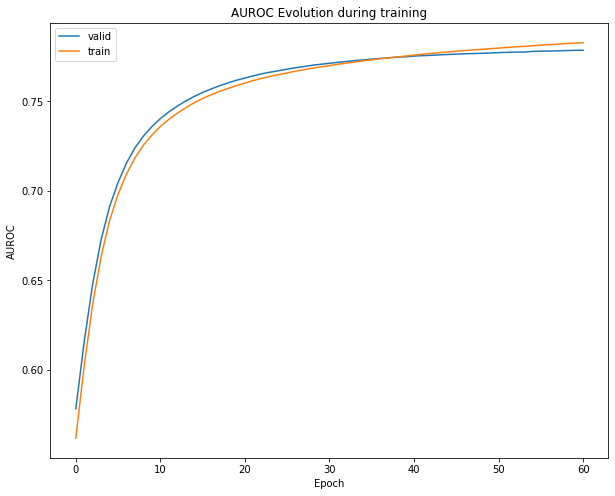

In [16]:
plt.figure(figsize=(10,8))
plt.plot(historical_aurocs['valid'], label='valid')
plt.plot(historical_aurocs['train'], label='train')
plt.title('AUROC Evolution during training')
plt.xlabel('Epoch')
plt.ylabel('AUROC')
plt.legend()

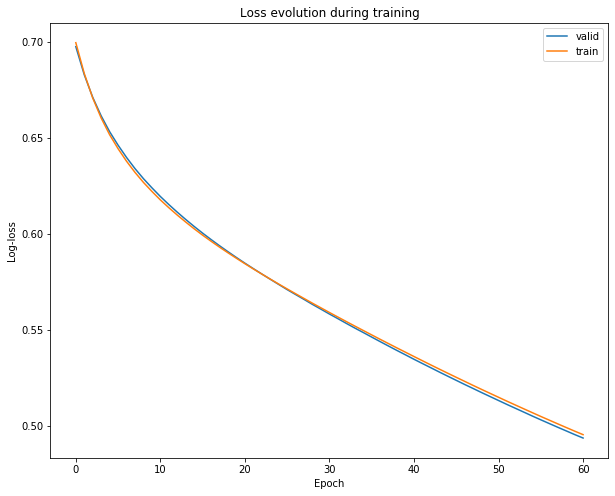

In [17]:
plt.figure(figsize=(10,8))
plt.plot(historical_loss['valid'], label='valid')
plt.plot(historical_loss['train'], label='train')
plt.title('Loss evolution during training')
plt.xlabel('Epoch')
plt.ylabel('Log-loss')
plt.legend()

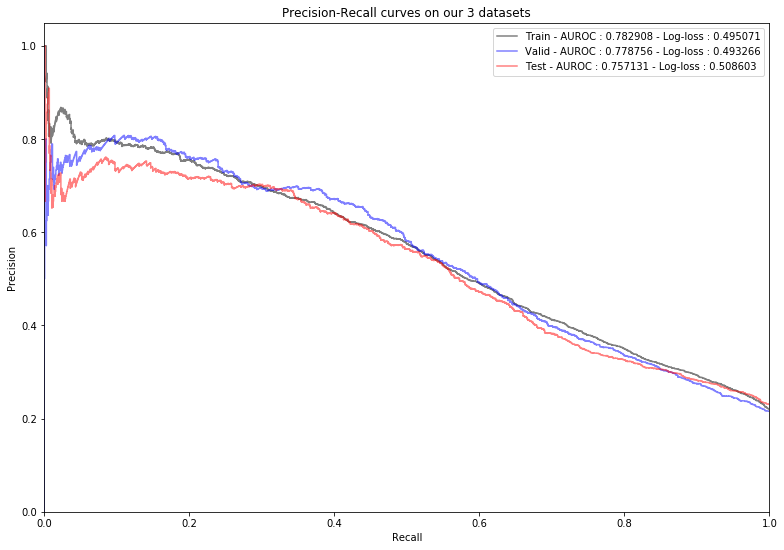

In [18]:
def plot_pr_curve(precision, recall, color, name, auroc, loss):
    
    #step_kwargs = ({'step': 'post'}
    #           if 'step' in signature(plt.fill_between).parameters
    #           else {})

    plt.step(recall, precision, color=color, alpha=0.5,
             where='post', label=name + ' - AUROC : {:f} - Log-loss : {:f}'.format(auroc, loss))
    

plt.figure(figsize=(13,9))

for dataset in [(X_train, y_train, 'black', 'Train'),
                (X_valid, y_valid, 'blue', 'Valid'),
                (X_test, y_test, 'red', 'Test')]:
    
    with torch.no_grad():

            X = torch.tensor(dataset[0].values.astype(np.float32))
            y = torch.tensor(dataset[1].values.astype(np.float32))
            net_out = net(X).detach().numpy()

            precision, recall, _  = precision_recall_curve(y.detach().numpy(), net_out)
            auroc = roc_auc_score(y.detach().numpy(), net_out)
            loss = log_loss(y.detach().numpy(), net_out)

    plot_pr_curve(precision, recall, dataset[2], dataset[3], auroc, loss)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall curves on our 3 datasets')
plt.legend()

## Hyperopt

In the past training, we fixed our hyperparameters in advance. In fact, they were previously found by manual trial and error. Perhaps there is better way to find a good combination of hyperparams without trying every possibility.

A package called Hyperopt can help us with that. It uses the Tree-structured Parzen Estimator (TPE) algorithm to explore the space more efficiently than randomly or exhaustively.

To use it, we will need to wrap all of our previous code inside one function, that we will call train_loop. This function will have a dictionary of hyperparameters as input. It will also receive by default our train and valid dataset splits.

In [19]:
def train_loop(params,
               X_train=X_train,
               y_train=y_train,
               X_test=X_test,
               y_test=y_test):
    
    N_INPUTS = X_train.shape[1]
    HIDDEN_UNITS = params['hidden_units']
    EPOCHS = 50
    BATCH_SIZE = params['batch_size']
    LEARNING_RATE = params['learning_rate']
    L2_REG = params['l2_reg']
    
    net = MLP(N_INPUTS, HIDDEN_UNITS, 1)

    optimizer = Adam(net.parameters(), lr=LEARNING_RATE, weight_decay=L2_REG, amsgrad=True)
    criterion = nn.BCELoss()
    
    historical_aurocs = {'train':[], 'valid':[]} 
    historical_loss = {'train':[], 'valid':[]} 
    
    # run the main training loop
    for epoch in tqdm(range(EPOCHS), desc='Epochs'):

        for i in range(len(X_train)//BATCH_SIZE + 1):

                start = i*BATCH_SIZE
                end = min((i+1)*BATCH_SIZE,len(X_train))

                X = torch.tensor(X_train[start:end].values.astype(np.float32))
                y = torch.tensor(y_train[start:end].values.astype(np.float32))

                optimizer.zero_grad()
                net_out = net(X)
                loss = criterion(net_out, y)
                loss.backward()
                optimizer.step()

        with torch.no_grad():

            X = torch.tensor(X_valid.values.astype(np.float32))
            y = torch.tensor(y_valid.values.astype(np.float32))
            net_out = net(X).detach().numpy()
            valid_auroc = roc_auc_score(y.detach().numpy(), net_out)
            valid_loss = log_loss(y.detach().numpy(), net_out)

            X = torch.tensor(X_train.values.astype(np.float32))
            y = torch.tensor(y_train.values.astype(np.float32))
            net_out = net(X).detach().numpy()
            train_auroc = roc_auc_score(y.detach().numpy(), net_out)
            train_loss = log_loss(y.detach().numpy(), net_out)

            historical_aurocs['valid'].append(valid_auroc)
            historical_aurocs['train'].append(train_auroc)

            historical_loss['valid'].append(valid_loss)
            historical_loss['train'].append(train_loss)
        
        X_train, y_train = shuffle(X_train, y_train)
    
    return min(historical_loss['valid'])

We can define our hyperparameter search space with prior knowledge of what could be good hyperparameters. After that, we can feed our train loop and our hyperparameter space in Hyperopt's optimizing function fmin. We have to specify a number of trials to limit the number of combinations we are willing to try. For this example, we use only ten trials to find a good set of hyperparameters because our time is limited. It is obviously too low considering there are $4^{4}=256$ possible combinations in our space.

In [20]:
hyperparam_space = {'l2_reg': hp.choice('l2_reg', [0.001,0.0001,0.00001,0.000001]),
                   'learning_rate': hp.choice('learning_rate', [0.001,0.0001,0.00001,0.000001]),
                   'hidden_units': hp.choice('hidden_units', [32, 64, 128, 256]),
                   'batch_size': hp.choice('batch_size', [32, 64, 128, 256])}

best = fmin(fn=train_loop,
            space=hyperparam_space,
            algo=tpe.suggest,
            max_evals=10)

  0%|          | 0/10 [00:00<?, ?it/s, best loss: ?]

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:23: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



  0%|          | 0/10 [00:03<?, ?it/s, best loss: ?]


KeyboardInterrupt: 

In [0]:
print('Our "optimal" hyperparameters are ...')
print(space_eval(hyperparam_space, best))